# Venice levels with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try the TTM-1024-96 model.

Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](https://huggingface.co/ibm/TTM).

## Defines and Imports

### Imports

In [1]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# First Party
from tsfm_public.models.tinytimemixer.utils import (
    count_parameters,
    plot_preds,
)

# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback

### Important arguments

In [2]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here ettm2)
# on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
# target_dataset = "ettm2"
# DATA_ROOT_PATH = "datasets/"

# DATA ROOT PATH
# Downloading Venice tide level dataset ICPSM
# Istituzione Centro Previsioni e Segnalazioni Maree 
# on the `DATA_ROOT_PATH` folder.
# CPSM  is available at: https://www.comune.venezia.it/node/6214
# in order to use icpsm you need to provide the needed configs to the TimeSeriesPreprocessor (TSP) module. 
# (tsfm/notebooks/hfdemo/tinytimemixer/utils/ttm_utils.py)
# TODO: add more data to dataset currently holding years 2021 2022 and 2023
target_dataset = "venice"
DATA_ROOT_PATH = "datasets/"


# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use "1024_96_v1" to use 1024-96 model
# PB67
# TTM_MODEL_REVISION = "main"
# TTM_INPUT_SEQ_LEN = 512
TTM_MODEL_REVISION = "1024_96_v1"
TTM_INPUT_SEQ_LEN = 1024


## Helper functions

### Get data from dataset

In [3]:
# Function to get_data
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

# Get data loaders using TSP
def get_data(
    dataset_name: str,
    context_length,
    forecast_length,
    fewshot_fraction=1.0,
    data_root_path: str = "datasets/",
):
    print(dataset_name, context_length, forecast_length)

    config_map = {
        # TODO: implement here data get utills 
        "venice": {
            #"dataset_path": "https://raw.githubusercontent.com/matteorinalduzzi/TTM/main/datasets/venice/venice_small.csv",
            "dataset_path": os.path.join(data_root_path, "venice/venice_small.csv"),
            "timestamp_column": "DATE",
            "id_columns": [],
            "target_columns": ["LEVEL"],
            #PB67
            "control_columns": ["PRESS", "WDIR", "WSPEED", "TEMP"], 
            # changed these settings with the ones below as they seem to return better predictions
            # TODO: understand differences and meaning of settings
            #"split_config": {
            #    "train": [0, 24 * 30 * 24],
            #    "valid": [24 * 30 * 24, 30 * 30 * 24],
            #    "test": [30 * 30 * 24, 36 * 30 * 24],
            #},
            "split_config": {
                "train": 0.7,
                "test": 0.2,
            },
        },
        "traffic": {
            "dataset_path": os.path.join(data_root_path, "traffic/traffic.csv"),
            "timestamp_column": "date",
            "id_columns": [],
            "target_columns": [],
            #PB67
            "control_columns": [], 
            "split_config": {
                "train": 0.7,
                "test": 0.2,
            },
        },
    }
    if dataset_name not in config_map.keys():
        raise ValueError(
            f"Currently `get_data()` function supports the following datasets: {config_map.keys()}\n \
                         For other datasets, please provide the proper configs to the TimeSeriesPreprocessor (TSP) module."
        )

    dataset_path = config_map[dataset_name]["dataset_path"]
    timestamp_column = config_map[dataset_name]["timestamp_column"]
    id_columns = config_map[dataset_name]["id_columns"]
    target_columns = config_map[dataset_name]["target_columns"]
    split_config = config_map[dataset_name]["split_config"]
    #PB67
    control_columns = config_map[dataset_name]["control_columns"]


    if target_columns == []:
        df_tmp_ = pd.read_csv(dataset_path)
        target_columns = list(df_tmp_.columns)
        target_columns.remove(timestamp_column)

    data = pd.read_csv(
        dataset_path,
        parse_dates=[timestamp_column],
    )

    column_specifiers = {
        "timestamp_column": timestamp_column,
        "id_columns": id_columns,
        "target_columns": target_columns,
        #PB67
        #"control_columns": [],
        "control_columns": control_columns,
    
    }

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
        data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
    )
    print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

    return train_dataset, valid_dataset, test_dataset


### Zero-shot evaluation method

In [4]:
def zeroshot_eval(
    dataset_name, 
    batch_size,
    #PB67
    # context_length=512,
    context_length=TTM_INPUT_SEQ_LEN,
    forecast_length=96,
    prediction_filter_length=None
):
    # Get data
    _, _, dset_test = get_data(dataset_name=dataset_name, 
                               context_length=context_length, 
                               forecast_length=forecast_length, 
                               fewshot_fraction=1.0,
                               data_root_path=DATA_ROOT_PATH
                              )
    
    # Load model
    if prediction_filter_length is None:
        zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm/TTM", revision=TTM_MODEL_REVISION
        )
    else:
        if prediction_filter_length <= forecast_length:
            zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
                "ibm/TTM", revision=TTM_MODEL_REVISION, prediction_filter_length=prediction_filter_length
            )
        else:
            raise ValueError(f"`prediction_filter_length` should be <= `forecast_length")
    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size
        )
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # plot
    plot_preds(trainer=zeroshot_trainer, dset=dset_test, plot_dir=os.path.join(OUT_DIR, dataset_name), plot_prefix="test_zeroshot", channel=0)

### Few-shot finetune and evaluation method

In [5]:
def fewshot_finetune_eval(
        dataset_name, 
        batch_size, 
        learning_rate=0.001,
        #PB67
        # context_length=512,
        context_length=TTM_INPUT_SEQ_LEN,
        forecast_length=96,
        fewshot_percent=5, 
        freeze_backbone=True,
        num_epochs=50,
        save_dir=OUT_DIR,
        prediction_filter_length=None
    ):
    
    out_dir = os.path.join(save_dir, dataset_name)
    
    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)
    
    # Data prep: Get dataset
    dset_train, dset_val, dset_test = get_data(
        dataset_name,
        context_length,
        forecast_length,
        fewshot_fraction=fewshot_percent / 100,
        data_root_path=DATA_ROOT_PATH
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        if prediction_filter_length is None:
            finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
                "ibm/TTM", revision=TTM_MODEL_REVISION, head_dropout=0.7
            )
        elif prediction_filter_length <= forecast_length:
            finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
                "ibm/TTM", revision=TTM_MODEL_REVISION, head_dropout=0.7, prediction_filter_length=prediction_filter_length
            )
        else:
            raise ValueError(f"`prediction_filter_length` should be <= `forecast_length")
    else:
        if prediction_filter_length is None:
            finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
                "ibm/TTM", revision=TTM_MODEL_REVISION,
            )
        elif prediction_filter_length <= forecast_length:
            finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
                "ibm/TTM", revision=TTM_MODEL_REVISION, prediction_filter_length=prediction_filter_length
            )
        else:
            raise ValueError(f"`prediction_filter_length` should be <= `forecast_length")
    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to=None,
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)
    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # plot
    plot_preds(trainer=finetune_forecast_trainer, dset=dset_test, plot_dir=os.path.join(OUT_DIR, dataset_name), plot_prefix="test_fewshot", channel=0)

## Run predictions on the dataset

### Zero-shot

venice 1024 96
Data lengths: train = 35705, val = 5167, test = 10426


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


  0%|          | 0/163 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 11.0158, 'eval_samples_per_second': 946.46, 'eval_steps_per_second': 14.797}


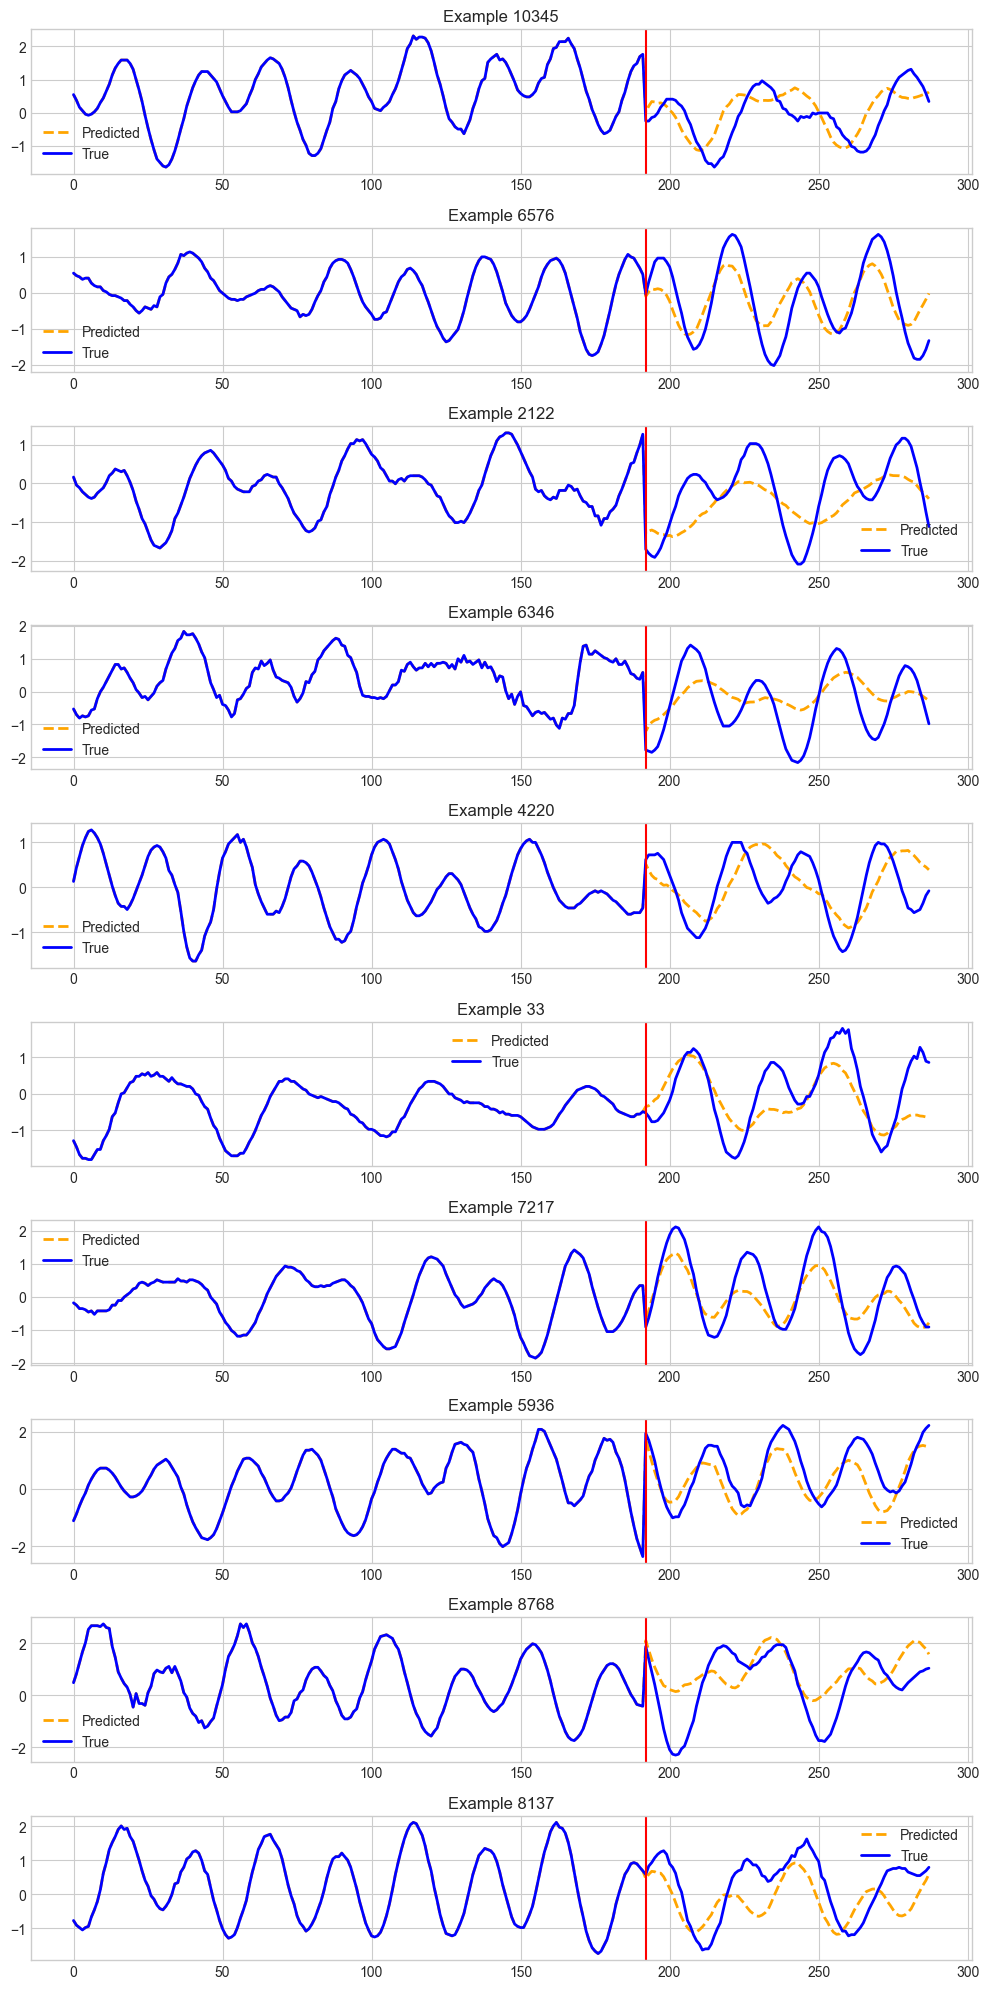

In [6]:
zeroshot_eval(dataset_name=target_dataset, batch_size=64)

### Few-shot 5%

-------------------- Running few-shot 5% --------------------
venice 1024 96
Data lengths: train = 1695, val = 5167, test = 10426
Number of params before freezing backbone 946336
Number of params after freezing the backbone 389984
Using learning rate = 0.001


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/1350 [00:00<?, ?it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 5.0540951278669186e-05, 'epoch': 1.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 54.0839, 'eval_samples_per_second': 95.537, 'eval_steps_per_second': 1.498, 'epoch': 1.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 8.1700839890263e-05, 'epoch': 2.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 53.5708, 'eval_samples_per_second': 96.452, 'eval_steps_per_second': 1.512, 'epoch': 2.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.0001321111038860165, 'epoch': 3.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 53.9702, 'eval_samples_per_second': 95.738, 'eval_steps_per_second': 1.501, 'epoch': 3.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.00019955769269624623, 'epoch': 4.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 53.7554, 'eval_samples_per_second': 96.121, 'eval_steps_per_second': 1.507, 'epoch': 4.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.0002810783096269476, 'epoch': 5.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 53.8061, 'eval_samples_per_second': 96.03, 'eval_steps_per_second': 1.505, 'epoch': 5.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.00037309251779781406, 'epoch': 6.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 53.8951, 'eval_samples_per_second': 95.871, 'eval_steps_per_second': 1.503, 'epoch': 6.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.00047155899518686896, 'epoch': 7.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 53.9474, 'eval_samples_per_second': 95.778, 'eval_steps_per_second': 1.501, 'epoch': 7.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.0005721530320410278, 'epoch': 8.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 53.8973, 'eval_samples_per_second': 95.867, 'eval_steps_per_second': 1.503, 'epoch': 8.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.0006704564748544392, 'epoch': 9.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 54.1674, 'eval_samples_per_second': 95.389, 'eval_steps_per_second': 1.495, 'epoch': 9.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.000762151774455347, 'epoch': 10.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 53.9427, 'eval_samples_per_second': 95.787, 'eval_steps_per_second': 1.502, 'epoch': 10.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.0008432116154871834, 'epoch': 11.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 53.9881, 'eval_samples_per_second': 95.706, 'eval_steps_per_second': 1.5, 'epoch': 11.0}
{'train_runtime': 1172.1755, 'train_samples_per_second': 72.301, 'train_steps_per_second': 1.152, 'train_loss': 0.0, 'epoch': 11.0}
[TrackingCallback] Mean Epoch Time = 52.57623880559748 seconds, Total Train Time = 1172.1764430999756
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


  0%|          | 0/163 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 59.2761, 'eval_samples_per_second': 175.889, 'eval_steps_per_second': 2.75, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


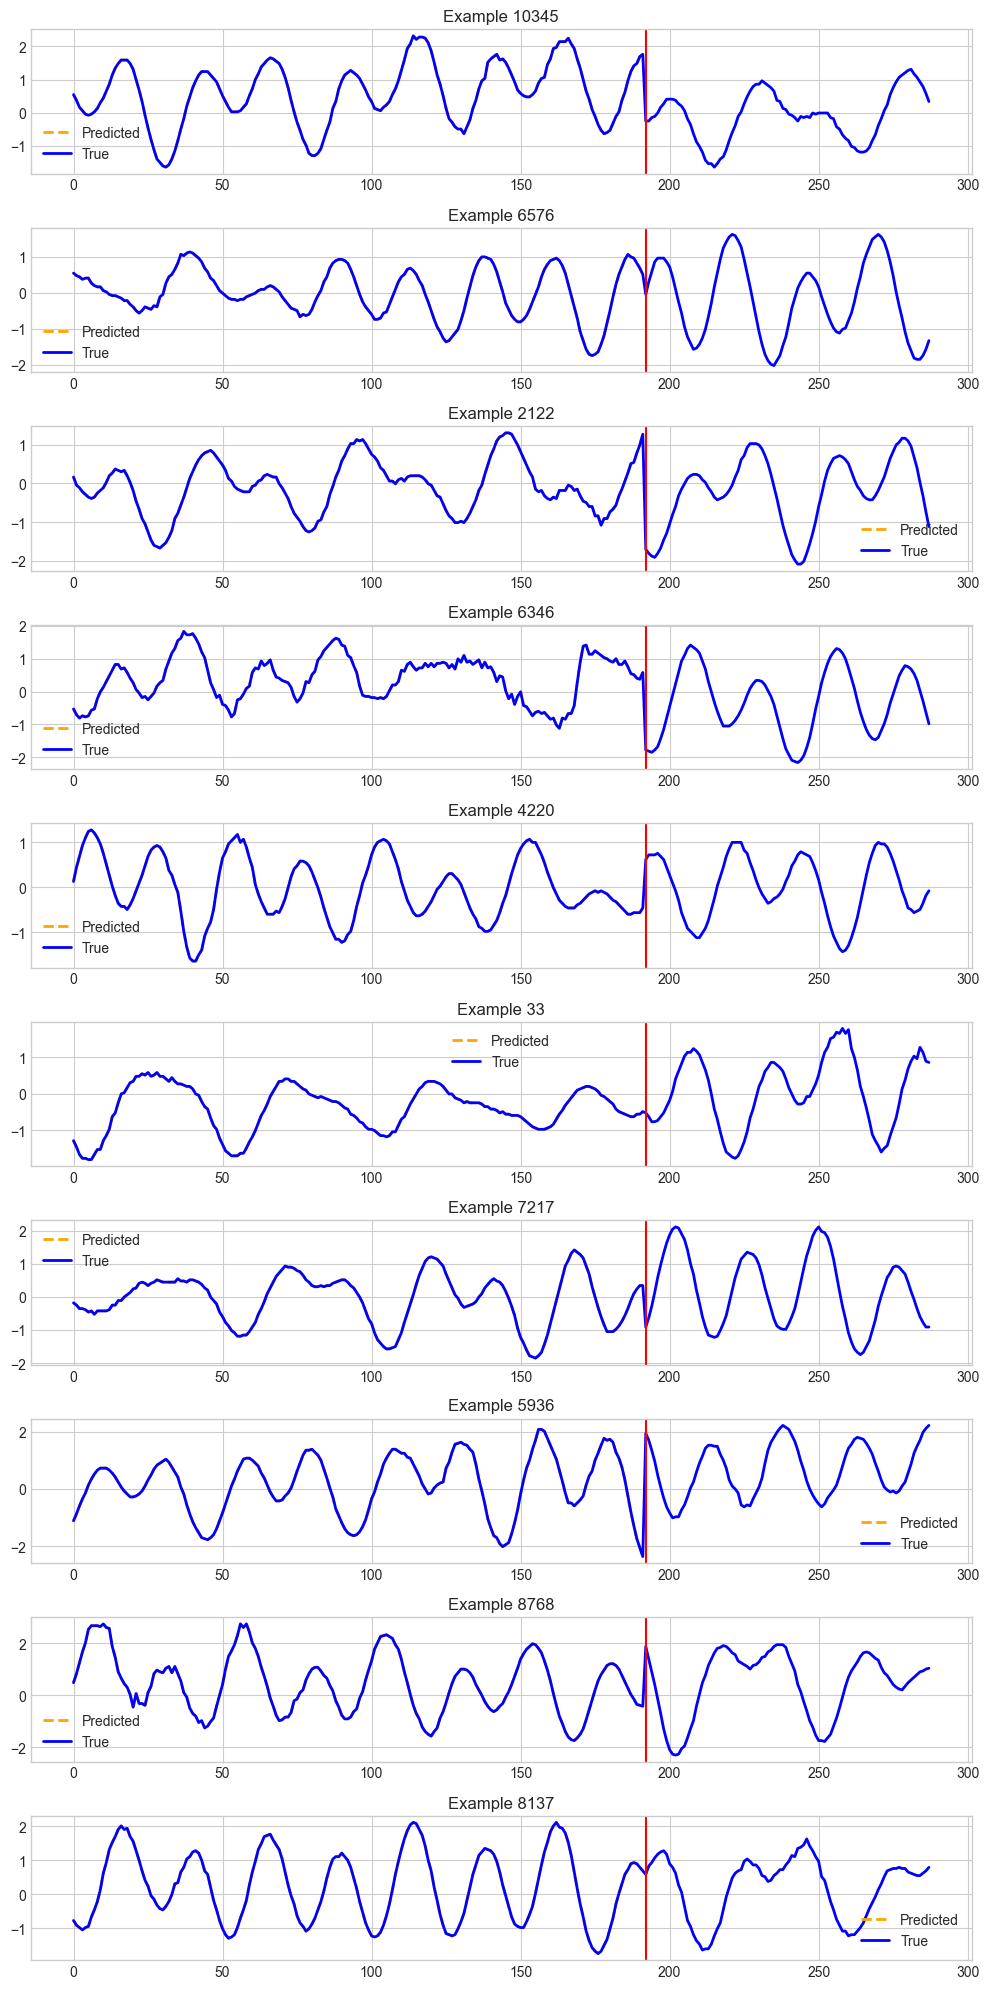

In [7]:
fewshot_finetune_eval(dataset_name=target_dataset, batch_size=64)

## Run predicitions on automatically truncated forecast horizon

Here, we demonstrate that a pre-trained 512-96 TTM model (i.e., context length = 512, forecast horizon = 96) 
can be used for a task having forecast horizon less than 96 time points.
We need to specify the argument `prediction_filter_length` while loading the model. That's it!

Note that the model performance might be sacrificed by some margin while truncating the model forecast. It is recommended to try 
this feature in your validation data for your experiment, to verify if the model performance is in the acceptable threshold. 
Otherwise, a new TTM model can be pre-trained with the required forecast horizon.

In this example, we will use a 512-96 TTM and use it on ettm2 data for forecasting 48 points in both zero-shot and 5% few-shot settings.

### Zero-shot

venice 1024 96
Data lengths: train = 35705, val = 5167, test = 10426
++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/163 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 10.8517, 'eval_samples_per_second': 960.772, 'eval_steps_per_second': 15.021}


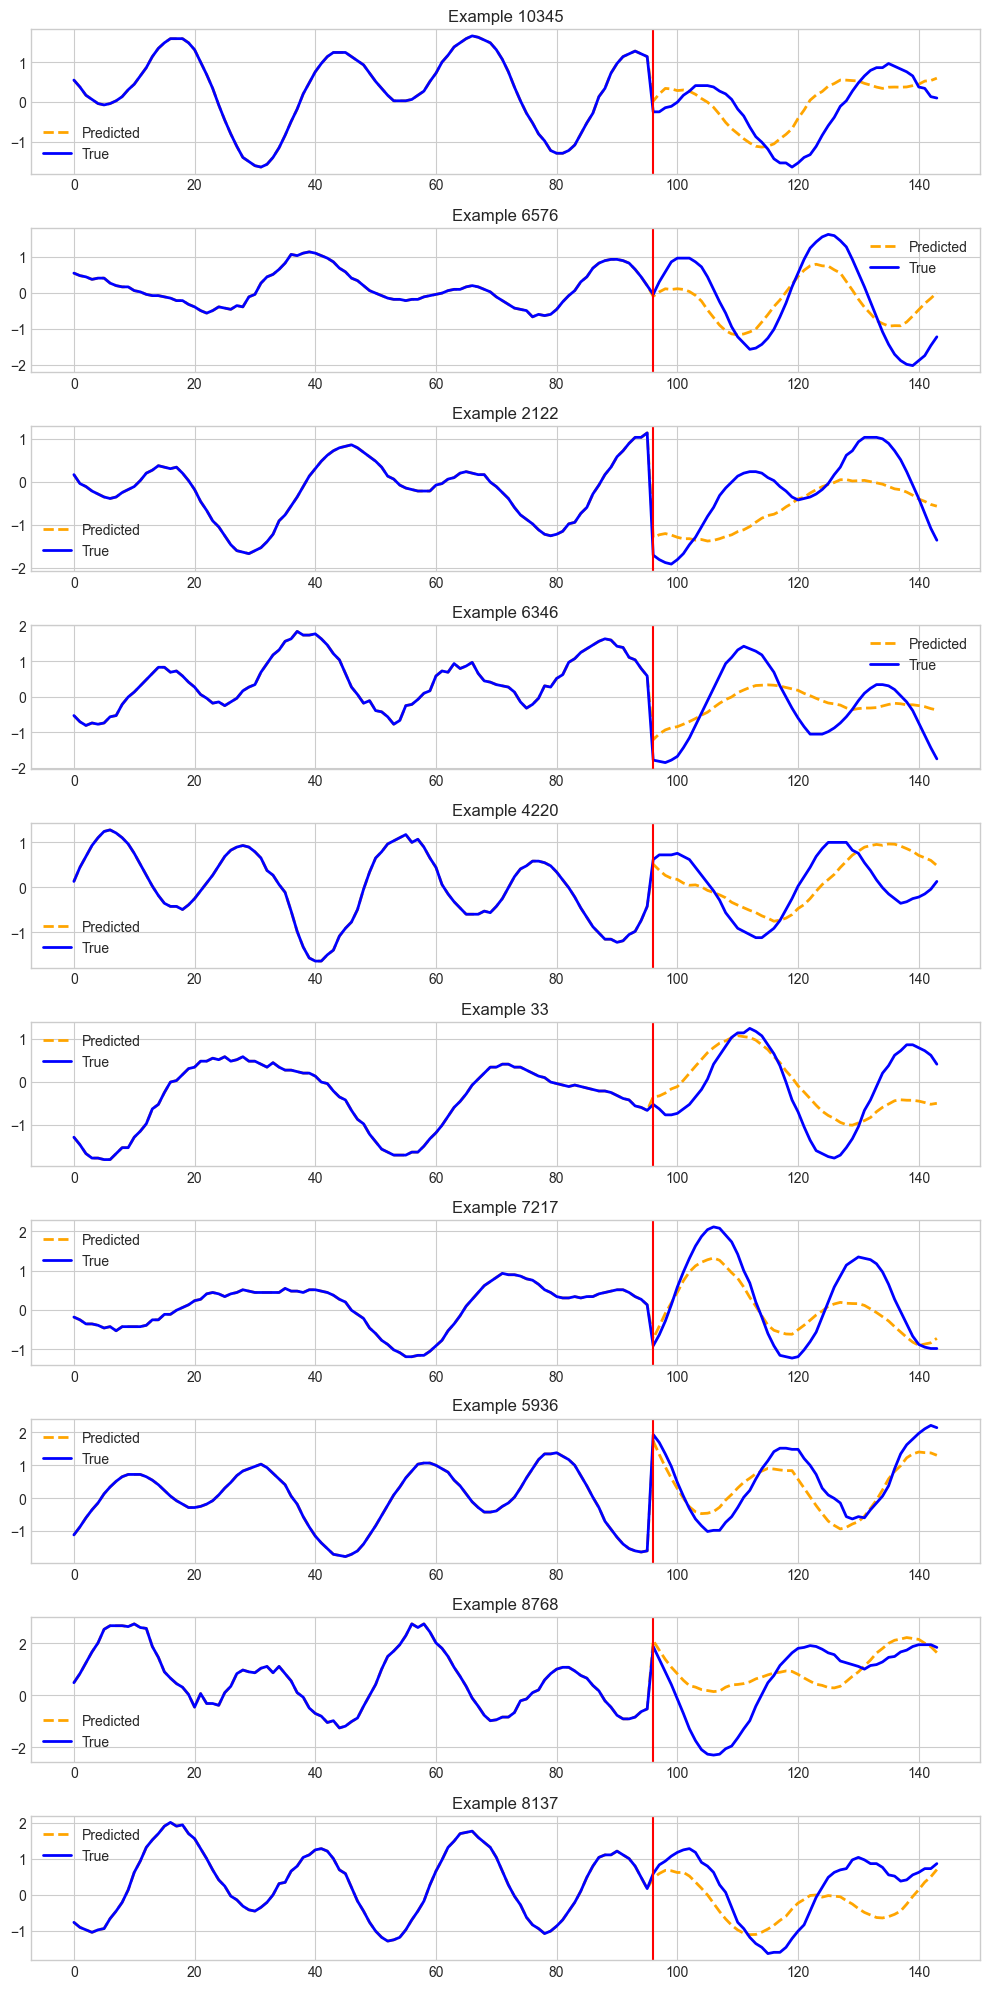

In [8]:
zeroshot_eval(dataset_name=target_dataset, batch_size=64, prediction_filter_length=48)

### Few-shot 5%

-------------------- Running few-shot 5% --------------------
venice 1024 96
Data lengths: train = 1695, val = 5167, test = 10426
Number of params before freezing backbone 946336
Number of params after freezing the backbone 389984
Using learning rate = 0.001


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/1350 [00:00<?, ?it/s]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 5.0540951278669186e-05, 'epoch': 1.0}


  0%|          | 0/81 [00:00<?, ?it/s]

Checkpoint destination directory ttm_finetuned_models/venice/output/checkpoint-27 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': nan, 'eval_runtime': 54.2619, 'eval_samples_per_second': 95.223, 'eval_steps_per_second': 1.493, 'epoch': 1.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 8.1700839890263e-05, 'epoch': 2.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 53.9793, 'eval_samples_per_second': 95.722, 'eval_steps_per_second': 1.501, 'epoch': 2.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.0001321111038860165, 'epoch': 3.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 54.0541, 'eval_samples_per_second': 95.589, 'eval_steps_per_second': 1.498, 'epoch': 3.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.00019955769269624623, 'epoch': 4.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 53.9882, 'eval_samples_per_second': 95.706, 'eval_steps_per_second': 1.5, 'epoch': 4.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.0002810783096269476, 'epoch': 5.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 53.9528, 'eval_samples_per_second': 95.769, 'eval_steps_per_second': 1.501, 'epoch': 5.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.00037309251779781406, 'epoch': 6.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 53.9635, 'eval_samples_per_second': 95.75, 'eval_steps_per_second': 1.501, 'epoch': 6.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.00047155899518686896, 'epoch': 7.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 54.0818, 'eval_samples_per_second': 95.54, 'eval_steps_per_second': 1.498, 'epoch': 7.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.0005721530320410278, 'epoch': 8.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 53.9263, 'eval_samples_per_second': 95.816, 'eval_steps_per_second': 1.502, 'epoch': 8.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.0006704564748544392, 'epoch': 9.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 53.2152, 'eval_samples_per_second': 97.096, 'eval_steps_per_second': 1.522, 'epoch': 9.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.000762151774455347, 'epoch': 10.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 53.6041, 'eval_samples_per_second': 96.392, 'eval_steps_per_second': 1.511, 'epoch': 10.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.0008432116154871834, 'epoch': 11.0}


  0%|          | 0/81 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 53.4546, 'eval_samples_per_second': 96.661, 'eval_steps_per_second': 1.515, 'epoch': 11.0}
{'train_runtime': 1170.627, 'train_samples_per_second': 72.397, 'train_steps_per_second': 1.153, 'train_loss': 0.0, 'epoch': 11.0}
[TrackingCallback] Mean Epoch Time = 52.48828203027899 seconds, Total Train Time = 1170.6276750564575
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


  0%|          | 0/163 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 58.329, 'eval_samples_per_second': 178.745, 'eval_steps_per_second': 2.794, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


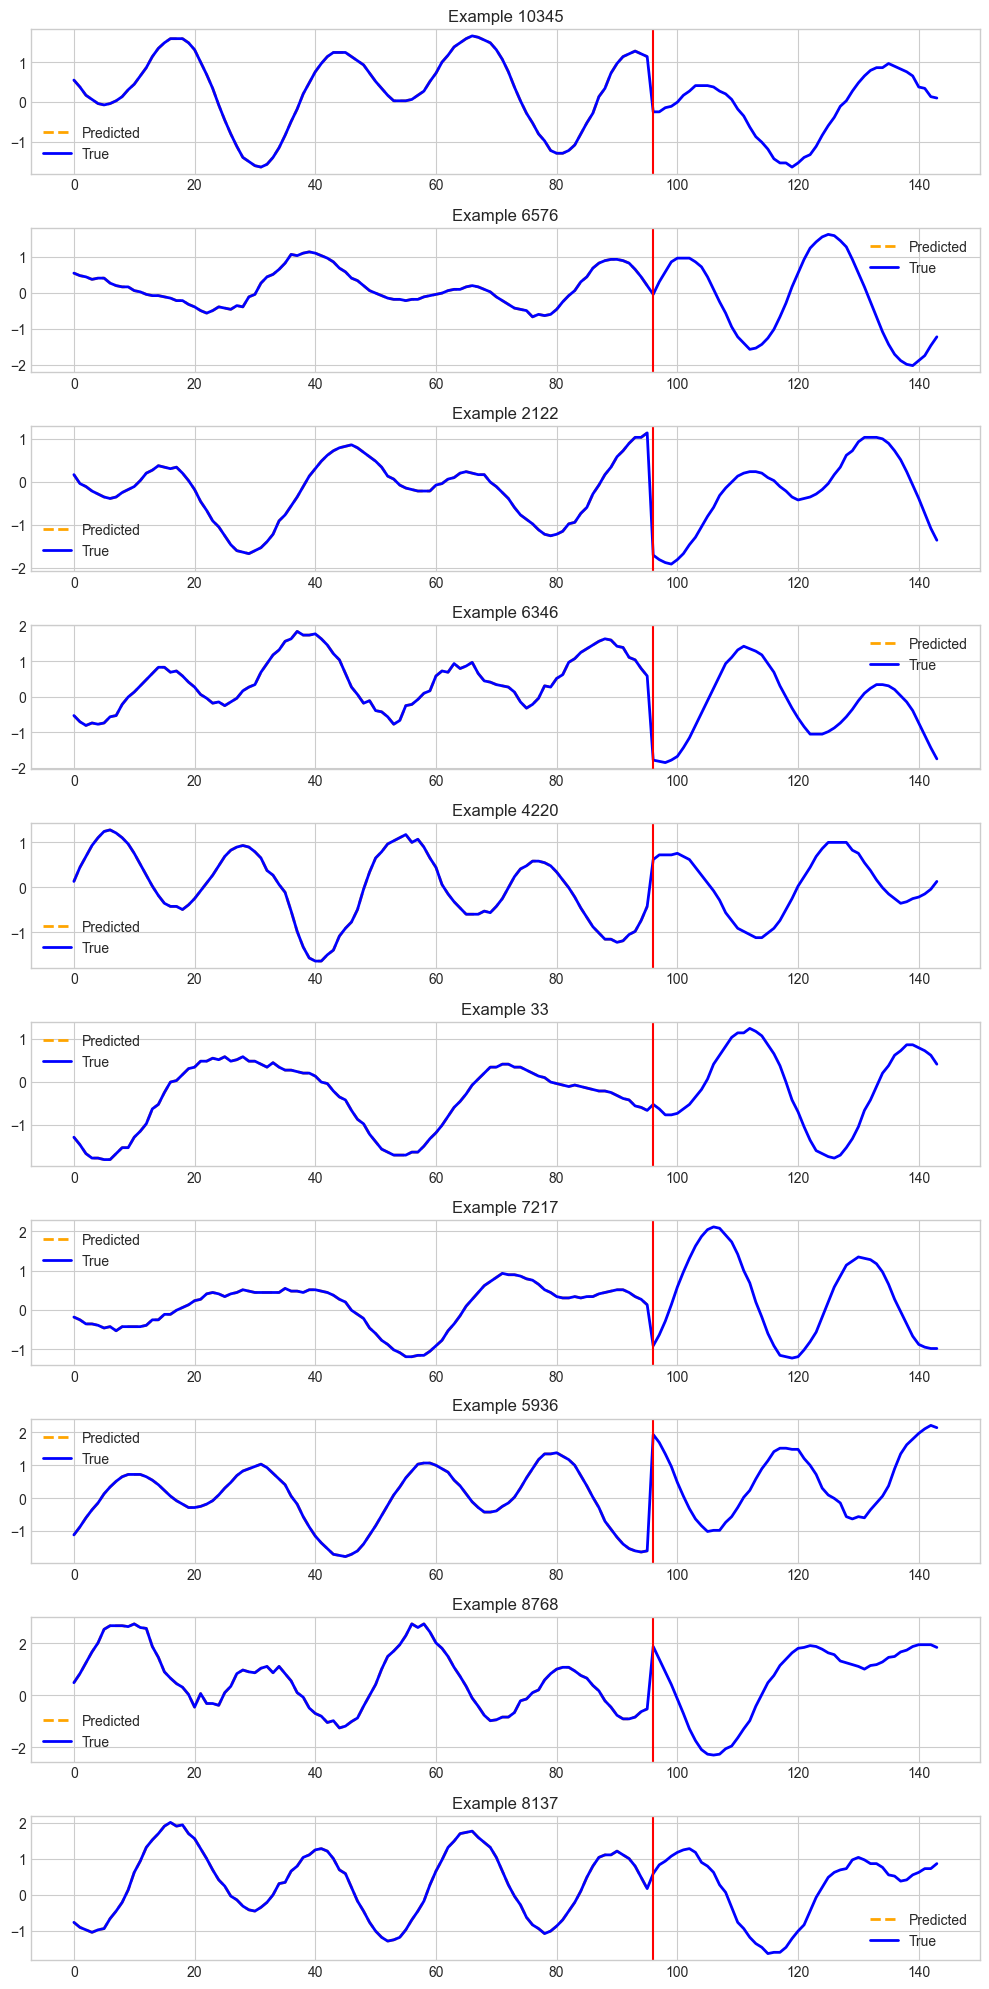

In [9]:
fewshot_finetune_eval(dataset_name=target_dataset, batch_size=64, prediction_filter_length=48)